# ECTA Cleaning

This notebook walks through how the ECTA articles were sorted into categories of articles and non-articles.

## Load Libraries

In [345]:
from tokenize import Ignore
from numpy import NaN
import numpy as np
import pandas as pd
import time
from os import path
import sys
from pathlib import Path
from PyPDF2 import PdfFileReader, PdfFileWriter
import re
import os
from difflib import SequenceMatcher
import datetime
import matplotlib.pyplot as plt

pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth', 120)   

## Load Files
Replace these file paths with local file paths

In [332]:
base_path="/Users/sijiawu/Work/Refs Danae/Thesis/Data"

In [333]:
masters = pd.read_excel(base_path+"/Masterlists/ECTA_Masterlist.xlsx")
masters10 = pd.read_excel(base_path+ "/2010/ECTA_master.xlsx")
pivots = pd.read_excel(base_path+"/Pivots/ECTA_Pivots2020.xlsx")
scopus = pd.read_excel(base_path+"/SCOPUS/ECTA_SCOPUS.xlsx")

## Create File names

In [334]:
saveas=base_path+"/Processed/ECTA_processed.xlsx"

## Some random checks on the masters list

My assumption is that all data without author names must be miscellaneous documents like reports by the committee, forewords, front matters etc.. The goal of this notebook is to check for certain that all the documents without author names are actually miscellaneous documents and then classify them as miscellaneous (MISC). Hence, first we group everything the data by title to see the repetitive general content that can likely be removed.

In [249]:
pd.set_option('display.max_rows',masters.shape[0])
temp=masters['title'].str.lower().value_counts()
pd.DataFrame(temp[temp>1]).head(10)

,count
title,
back matter,445
front matter,436
news notes,193
announcements,146
accepted manuscripts,116
volume information,80
submission of manuscripts to econometrica,49
forthcoming papers,42
report of the secretary,31


Some repetitions are due to multiple comments. Now consider this list in absence of author names.

In [250]:
temp1=masters[masters['author'].isna()]['title'].str.lower().value_counts()
pd.DataFrame(temp1).head(10)

,count
title,
back matter,445
front matter,436
news notes,193
announcements,134
accepted manuscripts,116
volume information,80
submission of manuscripts to econometrica,49
forthcoming papers,42
news note,25


In [251]:
# block for testing regex matching
#pd.DataFrame(masters[masters['content_type'].isna()]['title'].str.lower().value_counts())
#masters[masters['title'].str.lower().str.match(r'(^|: )report of the')]
#masters[masters['title'].str.lower().str.match(r'(^|.*: )report of the')]
#masters.loc[masters['title'].str.lower().str.match(r'^combined references(.*)')==True,'content_type']='MISC'
#masters[masters['title'].str.lower().str.match(r'.*(members|members and subscribers)$')]

Judging from the above anything with greater than or equal to 5 duplicates are miscellaneous. The next code blocks classify it as such.

In [335]:
masters["content_type"]=None
temp2=masters[masters['content_type'].isna()==True]['title'].str.lower().value_counts()
#pd.DataFrame(temp2)
removal=list(temp2[temp2>=5].index)
masters.loc[masters.title.str.lower().isin(removal),'content_type']='MISC'

## Combine the scraped list with the citations files

I have found that masterlists contructed from citation files lack the reviewed source's name while it is present on the page of the article. Some files are just missing the title. So I'm combining the old masterlists with the new ones.

In [336]:
masters["URL"]="https:"+masters["URL"].str.split(':').str[-1]
masters.drop('type', inplace=True, axis=1)
masters10["stable_url"]="https:"+masters10["stable_url"].str.split(':').str[-1]
masters10.rename(columns = {'authors':'author','stable_url':'URL','title':'title_10'}, inplace = True)
masters10.rename(columns = {'authors':'author','stable_url':'URL','title':'title_10'}, inplace = True)
scopus.rename(columns = {'abstract':'abstractSCO', 'title':'titleSCO', 'journal':'journalSCO', 'authors':'authorsSCO','issue':'number'}, inplace = True)
masters['pages']=masters['pages'].str.strip()  
masters.loc[masters.title.str.lower() == "back matter", 'pages'] = NaN  
pivots['type']=NaN
masters['pages']=masters["pages"].str.split('pp. ').str[-1]
masters['pages']=masters['pages'].replace(r'--','-',regex=True).str.strip()

In [337]:
masters["author_split"]=masters['author'].str.split(' and ')
masters=masters.merge(masters10[['URL', 'title_10']], how='left', on='URL')

In [338]:
masters.loc[(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==False), 'content_type']="Review"
masters.loc[((masters['title'].str.lower().str.contains('book reviews indexed by author of book')==True)),'content_type']='Review'

In [339]:
masters.loc[(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==False),"title"]=masters[(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==False)]["title_10"]
masters.loc[(pd.isna(masters["title_10"])==False)&(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==True)&(pd.isna(masters["author"])==True),"title"]=masters[(pd.isna(masters["title_10"])==False)&(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==True)&(pd.isna(masters["author"])==True)]["title_10"]

In [340]:
for i in masters[(pd.isna(masters["title_10"])==False)&(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==True)].index:
    temp=masters.iloc[i]
    indic=0
    if len(temp['author_split'])>1:
        for j in temp['author_split']:
            if j in temp["title_10"]:
                indic=1
                masters.loc[i, "title"]=temp["title_10"]
                masters.loc[i, "reviewed-author"]=j
                masters.loc[i, "content_type"]="Review"
                if "Review by:" in temp["title_10"]:
                    print("weird")
    if indic==0:
        masters.loc[i, 'title']=temp['title_10']

In [341]:
masters10.head()

,URL,author,title_10,abstract,content_type,issue_url,pages
0,https://www.jstor.org/stable/45238021,NaN,Front Matter,NaN,NaN,https://www.jstor.org/stable/10.2307/i40226149,NaN
1,https://www.jstor.org/stable/45238022,NaN,[Illustration],NaN,NaN,https://www.jstor.org/stable/10.2307/i40226149,NaN
2,https://www.jstor.org/stable/45238023,"Martin Beraja, Erik Hurst and Juan Ospina",THE AGGREGATE IMPLICATIONS OF REGIONAL BUSINESS CYCLES,NaN,NaN,https://www.jstor.org/stable/10.2307/i40226149,1789-1833
3,https://www.jstor.org/stable/45238024,Amanda Friedenberg,BARGAINING UNDER STRATEGIC UNCERTAINTY: THE ROLE OF SECOND-ORDER OPTIMISM,NaN,NaN,https://www.jstor.org/stable/10.2307/i40226149,1835-1865
4,https://www.jstor.org/stable/45238025,Gabriel Carroll and Georgy Egorov,STRATEGIC COMMUNICATION WITH MINIMAL VERIFICATION,NaN,NaN,https://www.jstor.org/stable/10.2307/i40226149,1867-1892


## Classifying miscellaneous content

In [259]:
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'front matter').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'back matter').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'news note(|s)').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'announcements').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'accepted manuscripts').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'volume information').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'submission of manuscripts to econometrica').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'forthcoming papers').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters['title'].str.lower().str.match(r'(^|.*: )report of the'), 'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'.*report (of|on) the(.*)(editors|fellows)'), 'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'meeting of the econometric society'), 'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'(^|.*: )report of the.*')==True,'content_type']="MISC"
masters.loc[(masters['title'].str.lower().str.contains('econometric society')==True)&(masters["author"].isna()==True),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains('econometrica')==True,'content_type']='MISC'
masters.loc[(masters['title'].str.lower().str.contains('report')==True) & (masters['author'].isna()==True),'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.strip().str.match(r'treasurer(.*)report'),'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.strip().str.contains(r'report from the president'),'content_type']='MISC'
masters.loc[((masters['title'].str.lower().str.contains('announcement of')==True)),'content_type']='MISC'
masters.loc[((masters['title'].str.lower().str.match(r'editor(.*)note')==True)),'content_type']='MISC'
masters.loc[((masters['title'].str.lower().str.match(r'(.*):program$')==True)),'content_type']='MISC'
masters.loc[((masters['title'].str.lower().str.strip().str.match(r'accountant(.*)opinion')==True)),'content_type']='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'unpublished research memoranda').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[((masters['title'].str.lower().str.strip().str.match(r'^(obituary|death(s?) of members)$')==True)),'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'.*fellows$'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains('nomination of fellows'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'.*editorial$'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'(index of authors|summary of accounts)'),'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'.*(members|members and subscribers)$'),'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains('\[illustration\]'),'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains('\[photograph.*\]'),'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains('abstracts of papers'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains('frisch medal award'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains('award of frisch'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'^membership list'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains('additive preferences'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains('communications'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains('letters to the editor'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'^program of.*'), 'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'.*: program'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains(r'call for papers'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'election of (new |)fellow(|s)'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'^index( of| to|$).*'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'^introduction.*'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains(r'notice of'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'meetings (in|of)'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains(r"société d'économétrie"), 'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains(r"election results"), "content_type"]="MISC"
masters.loc[masters['title'].str.lower().str.contains(r"compte.*congres"),"content_type"]="MISC"
masters.loc[masters['title'].str.lower().str.match(r"^(abbreviations|alphabetical list of periodicals|alphabetical list of associations, societies, etc.|author index|in memoriam|monograph prizes|national science foundation grant|news notes from other journals|nomination of fellow, 1984|north american regional conference|north american summer meeting, madison, wisconsin|note of appreciation|note on membership listing|notes of appreciation|notes to financial statements|omission of july issue|pagination error|postgraduate research in econometrics|postdoctoral study in statistics|reprints desired by european members|research information|second world congress|style manual|subject index|third world congress|travel grant to .* meeting|a note of appreciation|acknowledg(e|.)ment)$"),"content_type"]="MISC"
masters.loc[masters['title'].str.lower().str.match(r"^(announcement and tentative program|announcements and notes|announcements of the december 1957|appointment of co-editor|assistantships in econometrics|attendance at the oxford meeting, september 25-29, 1936|election of vice-president|fellowships|fellowships and grants|geographical list of subscribers|la conf.rence européenne de la soci.té d'.conometrie|miscellaneous index|north american summer meeting, madison, wisconsin|officers and council|officers and new council|plans for the atlantic city|plans for special publications|salute to ragnar frisch in honor of his sixty|rules for electing fellows as revised|statements of loss and fund balance for the years ended december|suggestions for fellowship|washington meeting with international|washington meeting, september|\[program\]: tenth indian econometric)|in memoriam \[yehuda grunfeld\]|obituary notice, dickson h. leavens|resumption of editorship by professor frisch"), "content_type"]="MISC"



## Classifying other content

In [260]:
sum(masters.content_type.isna())
#masters.shape[0]

5574

In [261]:
# masters.loc[masters['authors'].str.lower().str.match(r'^review(ed|) by(.*)')==True,'content_type']='Review' #reviews
# masters.loc[(masters['title'].str.lower().str.match(r'(.*) by (.*)')==True) & (masters.author.isna()==True),'content_type']=None 
masters.loc[~(masters['author'].isna()) & (masters['reviewed-author'].isna()==False),'content_type']='Review'

In [262]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )comment(|.*)$')==True,'content_type']='Comment'
masters[masters['content_type']=='Comment'].shape[0] #comments

73

In [263]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )reply(| to.*)$')==True,'content_type']="Reply"
masters[masters['content_type']=='Reply'].shape[0]

43

In [264]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )rejoinder.*$')==True,'content_type']="Rejoinder"
masters[masters['content_type']=='Rejoinder'].shape[0]

14

In [265]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )discussion$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(^|a )discussion(|.*)$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*:.*(|a )discussion(|s)$')==True,'content_type']='Discussion'
masters[masters['content_type']=='Discussion'].shape[0]

9

In [266]:
masters.loc[masters['content_type'].isna(),'content_type']="Article"
masters[masters['content_type']=='Article'].shape[0]

5435

In [267]:
#masters[masters['title'].str.lower().str.match(r'^\washington notes$')==True]
masters[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )rejoinder.*$')==True]

masters[masters.content_type=='Discussion'].shape[0]

9

## Summary Statistics

The values below show the full dataset. The masterlist is merged with pivot files to be able to sort by date.

In [268]:
pd.DataFrame(masters['content_type'].value_counts())

,count
content_type,
Article,5435
MISC,2890
Review,875
Comment,73
Reply,43
Rejoinder,14
Discussion,9


## Consider the pivots file
At times, conference papers are structured differently to normal articles. Hence, it may be necessary to distinguish conference papers from common articles.

In [269]:
pivots.loc[pivots.Jstor_issue_text.str.lower().str.match(r'(.*)(supplement|proceedings|annual meeting|survey|index|bibliographical directory)(.*)'),'type']="S"
pivots.loc[pivots.type.isna(),'type']='N'
pivots.type.value_counts()

type
N    447
S      8
Name: count, dtype: int64

Merge and calculate value counts of all the content types.

In [270]:
result = pd.merge(masters, pivots[['issue_url','type']], how="left", on=["issue_url", "issue_url"])

In [271]:
pd.DataFrame(result.content_type.value_counts())

,count
content_type,
Article,5435
MISC,2890
Review,875
Comment,73
Reply,43
Rejoinder,14
Discussion,9


In [272]:
pd.DataFrame(result[result.year>1939].content_type.value_counts())

,count
content_type,
Article,5232
MISC,2741
Review,875
Comment,73
Reply,41
Rejoinder,10
Discussion,9


In [273]:
pd.DataFrame(result[(result.year>1939) & (result.year<2011)].content_type.value_counts())

,count
content_type,
Article,4583
MISC,2515
Review,875
Comment,67
Reply,39
Rejoinder,10
Discussion,9


In [349]:
result.to_excel(saveas, index=False)

## This section aims to match up Scopus records and Jstor articles
If an article's affiliations, citations or abstracts are recorded on Scopus, I want to exclude them from the set of pdf's that are sent to docParser. Matching up the Scopus data is also useful for comparing the textual accuracy of OCR parsers. I use volume, issue, year and page numbers which are common to both the scopus data and the Jstor metadata to match articles. 

Then I use a sequence comparison between the journal titles of the matched articles to decide if the scopus data has been matched correctly. If the match ratio is below 70%, the title is investigated and if wrong, the scopus data for that matched article is eihter corrected or discarded. If the scopus data is missing all of affiliations, abstract and citations fields then the match is also discarded.

Finally, if the document type of scopus is different to the classification done during the cleaning section, the article is reclassified according to the Scopus document type.

In [317]:
cleaned=pd.read_excel(saveas)
scopus['pages']=scopus['pages'].str.strip()
print(scopus.shape)
cleaned.dtypes

(1716, 14)


issue_url                  object
ISSN                       object
URL                        object
journal                    object
number                     object
publisher                  object
title                      object
urldate            datetime64[ns]
volume                      int64
year                        int64
abstract                   object
author                     object
pages                      object
reviewed-author            object
uploaded                    int64
content_type               object
author_split               object
title_10                   object
type                       object
dtype: object

In [318]:
scopus.dtypes

authorsSCO         object
titleSCO           object
journalSCO         object
volume              int64
number             object
year                int64
pages              object
DOI                object
affiliations       object
abstractSCO        object
citations          object
document type      object
index keywords     object
author keywords    object
dtype: object

In [319]:
cleaned['volume']=cleaned['volume'].astype(int)
scopus['volume']=scopus['volume'].astype(int)

scopus['year']=scopus['year'].astype(int)
cleaned['year']=cleaned['year'].astype(int)

scopus['pages']=scopus['pages'].str.strip()
cleaned['pages']=cleaned['pages'].astype(str)

cleaned['number']=cleaned['number'].astype(str)
scopus=scopus[scopus.number.isna()==False].reset_index(drop =True)
scopus['number'] = scopus['number'].astype(int)
scopus['number'] = scopus['number'].astype(str)

In [320]:
Merged=pd.merge(cleaned, scopus, on=['year','number','volume','pages'], how='left')


In [322]:
#Note that we only have data up to 2020 in the masterlists because of the moving wall, but that's all that's required here so it's okay
print(sum(scopus['year']<=2020))
print(scopus.shape)

1635
(1716, 14)


In [323]:
# x=cleaned[['year','issue','volume','pages']].value_counts().reset_index()
# checks=pd.merge(cleaned, x, on=['year', 'issue','volume','pages'], how='left')
# y=pd.merge(checks[(pd.isna(checks[0])==False) & (checks[0]<2)], scopus, on=['year', 'issue','volume','pages'], how='left')
# temp=checks[checks[0]>=2].rename(columns={'authors':'authors_x','title':'title_x','abstract':'abstract_x','journal':'journal_x'})
# Merged=pd.concat([y,temp]).reset_index(drop=True)

In [324]:
count=0
for m in Merged.index:
    if(pd.isna(Merged.iloc[m]['titleSCO'])==False):
        ratio=SequenceMatcher(None, Merged.iloc[m]['title'].lower(), Merged.iloc[m]['titleSCO'].lower()).ratio()
        if((ratio<0.95) & (Merged.iloc[m]['content_type']!='MISC')):
            print(Merged.iloc[m]['year'])
            print(ratio)
            count+=1
            if (pd.isna(Merged.iloc[m]['author'])==False) & (pd.isna(Merged.iloc[m]['authorsSCO'])==False):
                A_ratio=SequenceMatcher(None, Merged.iloc[m]['author'].lower(), Merged.iloc[m]['authorsSCO'].lower()).ratio()
                print(A_ratio)
            else:
                print('Author issue')
                print(Merged.iloc[m]['author'])
                print(Merged.iloc[m]['authorSCO'])
            print(Merged.iloc[m]['URL'])
            print('vol: '+str(Merged.iloc[m]['volume']))
            print('issue: '+str(Merged.iloc[m]['number']))
            print('pages: '+Merged.iloc[m]['pages'])
            print('jstor: '+Merged.iloc[m]['title'])
            print('scopus: '+Merged.iloc[m]['titleSCO'])
            print('jstor: '+str(Merged.iloc[m]['author']))
            print('scopus: '+str(Merged.iloc[m]['authorsSCO']))
            print('scopus index: '+str(scopus[scopus['titleSCO']==Merged.iloc[m]['titleSCO']].index))
            print(m)
            print()
print(count)

2020
0.7323943661971831
0.4186046511627907
https://www.jstor.org/stable/48597216
vol: 88
issue: 5
pages: 2221-2228
jstor: CORRIGENDUM TO “TRADING AND INFORMATION DIFFUSION IN OVER-THE-COUNTER MARKETS”
scopus: Corrigendum to “TRADING AND INFORMATION DIFFUSION IN OVER-THE-COUNTER MARKETS”(Leisure/Loisir, (2012), 36, 1, (105), 10.3982/ECTA17318)
jstor: Ana Babus and Péter Kondor and Yilin Wang
scopus: Babus, A.--a--
Kondor, P.--b--
Wang, Y.--c-- 
scopus index: Index([1661], dtype='int64')
37

2014
0.803921568627451
0.44
https://www.jstor.org/stable/24029298
vol: 82
issue: 5
pages: 1945-1978
jstor: PERCEIVED AMBIGUITY AND RELEVANT MEASURES
scopus: Notes and comments: Perceived ambiguity and relevant measures
jstor: Peter Klibanoff and Sujoy Mukerji and Kyoungwon Seo
scopus: Klibanoff, P.--a--
Mukerji, S.--b--
Seo, K.--c-- 
scopus index: Index([1310], dtype='int64')
567

2013
0.7928994082840237
0.46296296296296297
https://www.jstor.org/stable/23357275
vol: 81
issue: 1
pages: 393-406
jstor: 

In [325]:
sum(Merged['titleSCO'].isna()==False)

1602

In [326]:
Merged.head()

,issue_url,ISSN,URL,journal,number,publisher,title,urldate,volume,year,...,authorsSCO,titleSCO,journalSCO,DOI,affiliations,abstractSCO,citations,document type,index keywords,author keywords
0,https://www.jstor.org/stable/10.2307/e48507458,"00129682, 14680262",https://www.jstor.org/stable/48628737,Econometrica,6,"[Wiley, The Econometric Society]",Front Matter,2023-09-05,88,2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.jstor.org/stable/10.2307/e48507458,"00129682, 14680262",https://www.jstor.org/stable/48628738,Econometrica,6,"[Wiley, The Econometric Society]",ON THE INFORMATIVENESS OF DESCRIPTIVE STATISTICS FOR STRUCTURAL ESTIMATES,2023-09-05,88,2020,...,"Andrews, I.--a-- --d--\nGentzkow, M.--b-- --d-- --d-- \nShapiro, J.M.--c-- --d-- --d--",On the Informativeness of Descriptive Statistics for Structural Estimates,Econometrica,10.3982/ECTA16768,"a--Department of Economics, Harvard University, United States\nb--Department of Economics, Stanford University, Unit...",We propose a way to formalize the relationship between descriptive analysis and structural estimation. A researcher ...,"Alatas, V., Banerjee, A., Hanna, R., Olken, B.A., Purnamasari, R., Wai-Poi, M.|Self-Targeting: Evidence From a Field...",Article,NaN,Local misspecification; transparency
2,https://www.jstor.org/stable/10.2307/e48507458,"00129682, 14680262",https://www.jstor.org/stable/48628739,Econometrica,6,"[Wiley, The Econometric Society]","A COMMENT ON: “On the Informativeness of Descriptive Statistics for Structural Estimates” by Isaiah Andrews, Matthew...",2023-09-05,88,2020,...,"Bonhomme, S.","A Comment on: “On the Informativeness of Descriptive Statistics for Structural Estimates” by Isaiah Andrews, Matthew...",Econometrica,10.3982/ECTA18789,"Department of Economics, University of Chicago, United States",NaN,"Andrews, I., Gentzkow, M., Shapiro, J.M.|Measuring the Sensitivity of Parameter Estimates to Estimation Moments|(201...",Article,NaN,NaN
3,https://www.jstor.org/stable/10.2307/e48507458,"00129682, 14680262",https://www.jstor.org/stable/48628740,Econometrica,6,"[Wiley, The Econometric Society]","A COMMENT ON: “On the Informativeness of Descriptive Statistics for Structural Estimates” by Isaiah Andrews, Matthew...",2023-09-05,88,2020,...,"Kitamura, Y.","A Comment on: “On the Informativeness of Descriptive Statistics for Structural Estimates” by Isaiah Andrews, Matthew...",Econometrica,10.3982/ECTA18788,"Department of Economics, Cowles Foundation, Yale University, United States",NaN,"Andrews, I., Gentzkow, M., Shapiro, J.M.|Measuring the Sensitivity of Parameter Estimates to Estimation Moments|(201...",Article,NaN,NaN
4,https://www.jstor.org/stable/10.2307/e48507458,"00129682, 14680262",https://www.jstor.org/stable/48628741,Econometrica,6,"[Wiley, The Econometric Society]","A COMMENT ON: “On the Informativeness of Descriptive Statistics for Structural Estimates” by Isaiah Andrews, Matthew...",2023-09-05,88,2020,...,"Santos, A.","A Comment on: “On the Informativeness of Descriptive Statistics for Structural Estimates” by Isaiah Andrews, Matthew...",Econometrica,10.3982/ECTA18787,"Department of Economics, UCLA, United States",NaN,"Andrews, I., Gentzkow, M., Shapiro, J.M.|(2020) On the Informativeness of Descriptive Statistics for Structural Esti...",Article,NaN,NaN


In [327]:
Merged.to_excel(base_path+'/Combined/ECTA_M_sco_du.xlsx', index=False)

In [328]:
Merged=pd.read_excel(base_path+'/Combined/ECTA_M_sco_du.xlsx')

## Scopus Coverage
Some plots to visualize scopus coverage for references and affiliations.

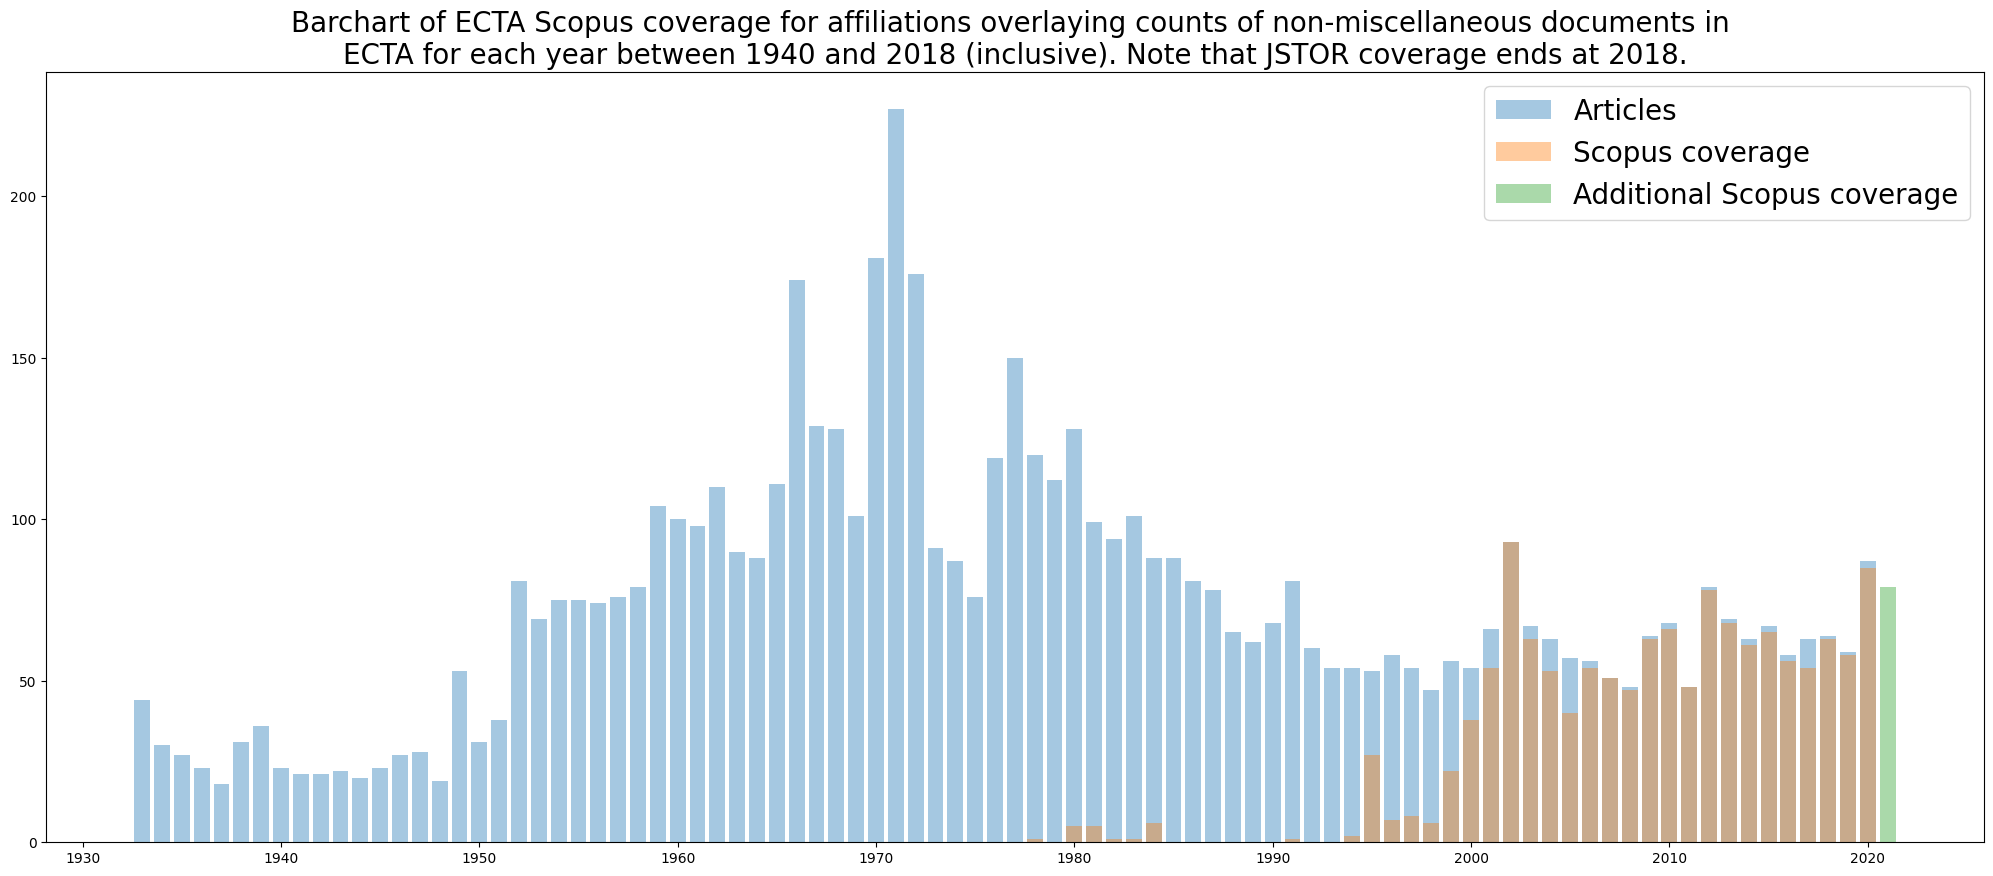

In [329]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged[(Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta.index,dta, label='Articles', alpha=0.4)
dta2=Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
dta3=scopus[(scopus['affiliations'].isnull()==False) & (scopus['year']>2020)]['year'].value_counts()
plt.bar(dta2.index, dta2, label='Scopus coverage', alpha=0.4)
plt.bar(dta3.index, dta3, label='Additional Scopus coverage', alpha=0.4)
plt.title('Barchart of ECTA Scopus coverage for affiliations overlaying counts of non-miscellaneous documents in \nECTA for each year between 1940 and 2018 (inclusive). Note that JSTOR coverage ends at 2018.', fontsize=20)
plt.xticks(np.arange(1930, 2030, 10))
plt.legend(prop={'size': 20})

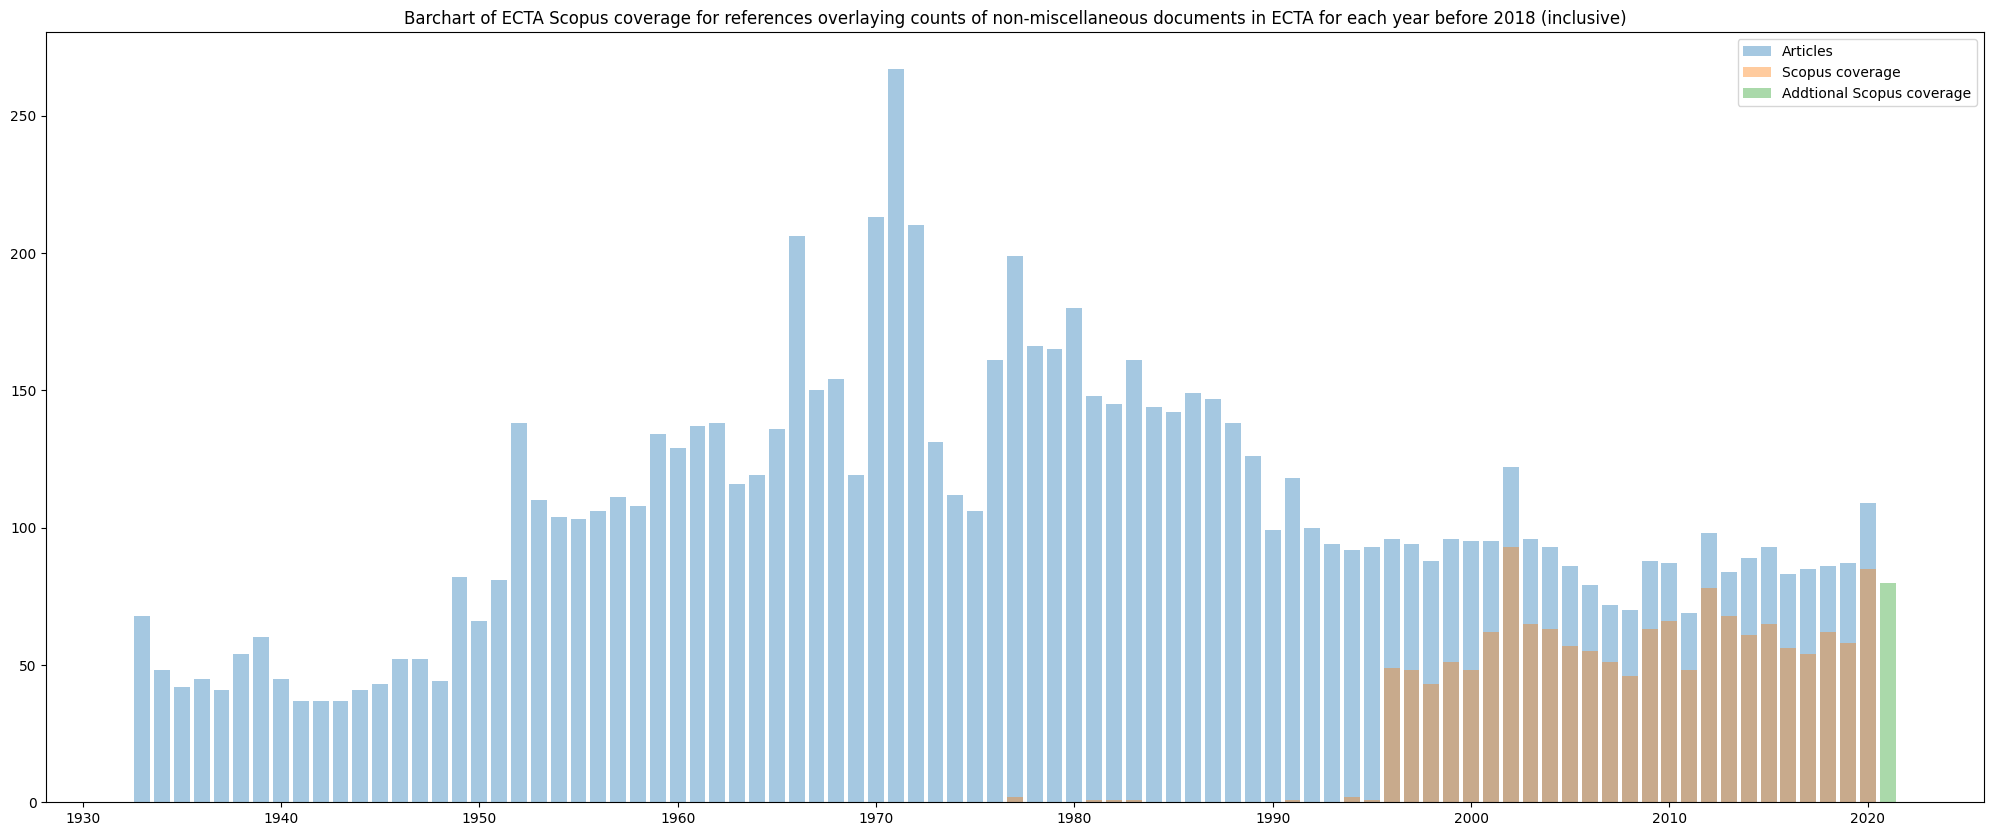

In [330]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged['year'].value_counts()
dta.index
plt.bar(dta.index, dta, alpha=0.4, label='Articles')

dta4=Merged[(Merged['citations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta4.index, dta4, alpha=0.4, label='Scopus coverage')
dta5=scopus[(scopus['citations'].isnull()==False) & (scopus['year']>2020)]['year'].value_counts()
plt.bar(dta5.index, dta5, alpha=0.4, label='Addtional Scopus coverage')
plt.title('Barchart of ECTA Scopus coverage for references overlaying counts of non-miscellaneous documents in ECTA for each year before 2018 (inclusive)')
plt.xticks(np.arange(1930, 2030, 10))
plt.legend()